# Installation

In [2]:
!git clone https://github.com/TheShenk/hai-nonconflict-action-learning.git

Cloning into 'hai-nonconflict-action-learning'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 83 (delta 25), reused 43 (delta 17), pack-reused 30
Unpacking objects: 100% (83/83), done.


In [1]:
!cd hai-nonconflict-action-learning/

/content/hai-nonconflict-action-learning


In [2]:
!pip install stable-baselines3[extra] pymunk pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [2]:
import gym
import gym_futbol
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from tqdm.notebook import tqdm
import utils
from multiagent import MultiAgentOnPolicyProxy, multiagent_learn

pygame 2.1.0 (SDL 2.0.16, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Basics

Reset


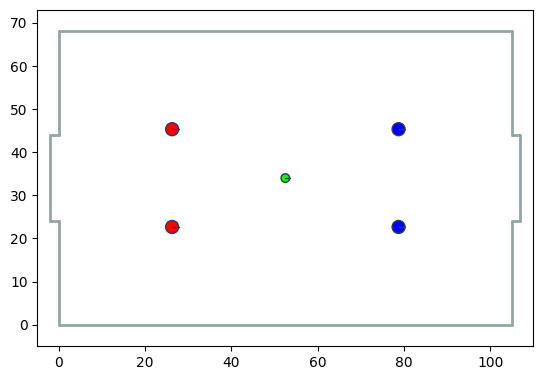

In [2]:
env = gym.make("Futbol2v2-v1")
env.render()

In [5]:
env.action_space

MultiDiscrete([5 5 5 5])

In [6]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

# Learning model

In [2]:
log_dir = "logs/"
timesteps = 50000

In [3]:
from stable_baselines3.common.env_util import make_vec_env

env = gym.make("Futbol2v2-v1")
env = make_vec_env(lambda: env, n_envs=4, monitor_dir=log_dir)
model = A2C("MlpPolicy", env, device='cpu')
model.learn(timesteps)
model.save("models/footbol2v2-ppo")

# Display model statistic

     index            r   l          t
0        0   155.344302  75   0.836995
1        1    37.251805  75   1.236683
2        2   246.193750  75   1.547551
3        3 -1014.314991  75   1.856825
4        4   295.685775  75   2.164369
..     ...          ...  ..        ...
161    161  1597.695812  75  57.009118
162    162   -56.477502  75  57.346870
163    163  2567.793982  75  57.695286
164    164   363.661477  75  58.012881
165    165   113.101150  75  58.335833

[166 rows x 4 columns]


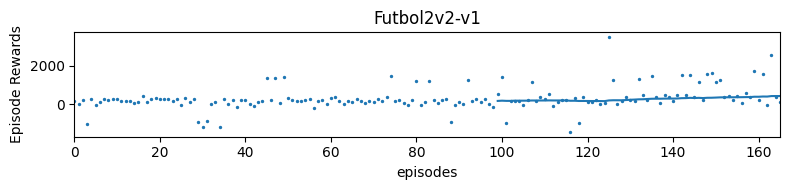

In [4]:
from IPython import display
from stable_baselines3.common import results_plotter

results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

log_data = results_plotter.load_results(log_dir)
print(log_data)

# Load model from file

In [12]:
model = A2C.load("models/footbol2v2-a2c", device="cpu")

# Run models

## Pygame
Run game with model in new windows with pygame

In [13]:
RES = WIDTH, HEIGHT = 600, 600
FPS = 60

env = gym.make("Futbol2v2-v1", width=WIDTH-2, height=HEIGHT-2, player_radius=15, ball_radius=5)
visualizer = utils.PygameVisualizer(env, FPS)
visualizer.run(model)

env.close()
visualizer.close()

## Matplotlib
Run model in notebook with matplotlib

KeyboardInterrupt: 

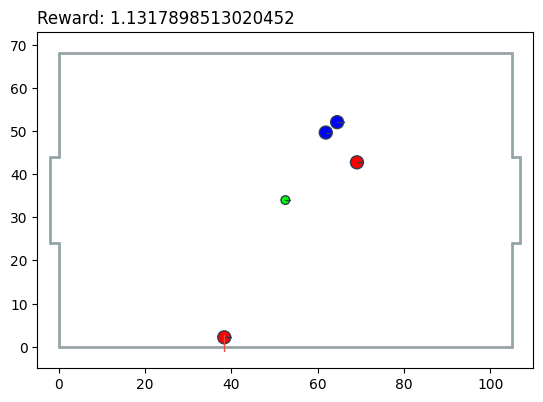

In [25]:
env = gym.make("Futbol2v2-v1")

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(model)

env.close()

# MultiAgent

## Learn

In [3]:
env = make_vec_env(lambda: gym.make("Futbol2v2-v1"), n_envs=1)

models = [
    MultiAgentOnPolicyProxy(A2C("MlpPolicy",
                             utils.TransformAction(env, lambda a: a[:2], gym.spaces.MultiDiscrete([5, 5])),
                             device='cpu')),
    MultiAgentOnPolicyProxy(A2C("MlpPolicy",
                             utils.TransformAction(env, lambda a: a[2:], gym.spaces.MultiDiscrete([5, 5])),
                             device='cpu'))
]

timesteps = 50000
n_records_count = models[0].model.n_steps
max_episode_reward = 0

### Rewrote learning cycle
StableBaselines3 не поддерживает одновременное обучение нескольких агентов, это даже не ошибка по мнению разработчиков. Они считают, что в данном случае каждому пользователю необходимо самостоятельо переопределить цикл обучения (для не мультиагентных задач используется метод learn). Здесь представлен код, взятый из исходных кодов StableBaselines3, но адаптированный для многоагентных задач.
В обычной ситуации, learn сам взаимодействует со средой. Но при существовании нескольких агентов нужно получить действие от каждого и только потом передавать их в среду. Именно это здесь и реализовано. Каждому агенту передается наблюдение от среды (в данной задаче оно одинаково для всех) и получается действие. Затем действия объеядиняются и передаются среде. Затем каждый агент обновляется с учетом полученных данных (метод record).
Весь код, взятый из StableBaselines3 вынесен в класс MultiAgentModelProxy.

In [4]:
#TODO: рассмотреть возможность асинхронной среды
#TODO: добавить вывод логов для последующего использования results_plotter

In [5]:
multiagent_learn(models, timesteps, env, n_records_count, "models/footbol2v2-a2c")

/tmp/ipykernel_19276/542755898.py:1: DeprecationWarning: Parameters `eval_env` and `eval_freq` are deprecated and will be removed in the future. Please use `EvalCallback` or a custom Callback instead.
  multiagent_learn(models, timesteps, env, n_records_count, "models/footbol2v2-a2c")


5 [1.9253747]
10 [7.3498983]
15 [8.784355]
20 [12.19653]
25 [12.308838]
30 [7.1100416]
35 [4.345506]
40 [9.901191]
45 [18.40208]
50 [20.070072]
55 [35.252544]
60 [32.219555]
65 [13.464296]
70 [10.476499]
75 [16.167078]
80 [26.750584]
85 [30.097769]
90 [20.126814]
95 [16.89652]
100 [28.016003]
105 [24.652617]
110 [19.215944]
115 [20.218132]
120 [20.12336]
125 [22.626549]
130 [38.436012]
135 [60.192085]
140 [137.088]
145 [125.8886]
150 [107.64079]
155 [81.094406]
160 [40.762894]
165 [3.2816575]
170 [-8.756359]
175 [-17.261293]
180 [963.9484]
185 [8.246763]
190 [9.74705]
195 [3.2265797]
200 [1.4481966]
205 [6.933424]
210 [8.754395]
215 [8.718008]
220 [-2.3598826]
225 [-1.2685511]
230 [2.4384317]
235 [2.1358082]
240 [6.180801]
245 [12.562841]
250 [8.388166]
255 [0.6536126]
260 [-2.0305357]
265 [6.8947735]
270 [11.258464]
275 [10.699181]
280 [16.683733]
285 [19.101786]
290 [22.244978]
295 [24.279848]
300 [26.025024]
305 [6.375474]
310 [21.498268]
315 [19.870968]
320 [21.258316]
325 [18.5285

KeyboardInterrupt: 

## Load and visualise

In [7]:
from stable_baselines3 import PPO

models = [PPO.load(f"models/footbol2v2-ppo-last-{index}", device="cpu") for index in range(2)]

In [8]:
env = gym.make("Futbol2v2-v1")

multi_agent = utils.MultiModelAgent(models)

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(multi_agent)

env.close()

ValueError: zero-dimensional arrays cannot be concatenated